This notebook uses the `dilithium-py` library hosted on https://github.com/GiacomoPope/dilithium-py. Note that this library is for educational purposes only and should

✨ NOT BE USED IN TEST OR PRODUCTION ENVIRONMENTS UNDER NO CIRCUMSTANCES EVER ✨ 

<img src="../images/dilithium-py-warning" width="800">

## Setup and Helper Functions

Before diving into Dilithium, we prepare some helper functions for later. This may take some time to compute the first time, so we can look at the mathematical background in the meantime.

In [87]:
from typing import List, Tuple, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Do not use the following library in prod environments EVER
# It was built for educational purposes only and is not secure against side-channel attacks
# Refer to e.g. Open Quantum Safe (liboqs) for constant-time implementations
from dilithium_py.dilithium import Dilithium2

def _polyvec_to_coeff_lists(polyvec) -> List[List[int]]:
    return [poly.coeffs for row in polyvec._data for poly in row]

def poly_to_string(coeffs, max_terms=12):
    terms = []

    for i, c in enumerate(coeffs[:max_terms]):
        if c == 0:
            continue

        sign = "-" if c < 0 else "+"
        abs_c = abs(c)

        if i == 0:
            term = f"{abs_c}"
        elif i == 1:
            term = f"{abs_c}x"
        else:
            term = f"{abs_c}x^{i}"

        terms.append((sign, term))

    if not terms:
        return "0"

    first_sign, first_term = terms[0]
    result = first_term if first_sign == "+" else f"-{first_term}"

    for sign, term in terms[1:]:
        result += f" {sign} {term}"

    return result + " + ..."

def unpack_pk_dilithium2(pk: bytes) -> Tuple[bytes, List[List[int]]]:
    rho, t1 = Dilithium2._unpack_pk(pk)
    t1_coeffs = _polyvec_to_coeff_lists(t1)
    return rho, t1_coeffs


def unpack_sk_dilithium2(sk: bytes) -> Dict[str, Any]:
    rho, key_seed, tr, s1, s2, t0 = Dilithium2._unpack_sk(sk)

    return {
        "rho": rho,
        "key_seed": key_seed,
        "tr": tr,
        "s1": _polyvec_to_coeff_lists(s1),
        "s2": _polyvec_to_coeff_lists(s2),
        "t0": _polyvec_to_coeff_lists(t0),
    }

def unpack_sig_dilithium2(sig: bytes) -> Dict[str, Any]:
    c, z, h = Dilithium2._unpack_sig(sig)
    return {
        "c": c,
        "z": _polyvec_to_coeff_lists(z),
        "h": _polyvec_to_coeff_lists(h), 
    }

## Dilithium Introduction

Dilithium is is digital signature algorithm designed to be secure against quantum computers. It is based on the hardness of lattice problems, specifically the Module Learning With Errors (Module-LWE) and Module Short Integer Solution (Module-SIS) problems.

Key Dilithium facts:
- Selected by NIST in 2022 for standardization (FIPS 204 ML-DSA)

- Designed by the CRYSTALS team (same family as Kyber KEM) - see https://pq-crystals.org/

- Constructed using a non-interactive Fiat–Shamir transform, essentially a lattice-based version of Schnorr signatures

## Mathematical Background

Dilithium works in a module over the polynomial ring

$$
R_q = \mathbb{Z}_q[x] / (x^{n} + 1)
$$

with parameters $q = 8380417$ and $n = 256$.

This means that public and secret keys in Dilithium are vectors of polynomials with 256 coefficients.

One polynomial in the ring $R_q$:

$$
f(x) = a_0 + a_1 x + a_2 x^2 + \cdots + a_{255} x^{255}
$$

One vector of polynomials in the module $R_q^k$ (where $k$ = 4 for Dilithium2):
$$
\mathbf{v} =
\begin{pmatrix}
a^0_0 + a^0_1 x + a^0_2 x^2 + \cdots + a^0_{255} x^{255} \\
a_0^1 + a_1^1 x + a_2^1 x^2 + \cdots + a_{255}^1 x^{255} \\
a_0^2 + a_1^2 x + a_2^2 x^2 + \cdots + a_{255}^2 x^{255} \\
a_0^3 + a_1^3 x + a_2^3 x^2 + \cdots + a_{255}^3 x^{255}
\end{pmatrix}
\in R_q^4
$$
Each component polynomial in this vector:

- Has 256 coefficients  
- Is reduced modulo $q = 8380417$  
- Is computed modulo $x^{256} + 1$

## Generate a Dilithium2 Keypair

We generate a keypair for Dilithium2, the NIST-2 level parameter set for Dilithium.

1. Generate a public matrix $A \in R_q^{k \times l}$ deterministically from a public seed $\rho$:

$$
A = \mathrm{ExpandA}(\rho)
$$

2. Sample small secret polynomials $s_1$ and $s_2$ ("small" = small coefficients centered around zero):

$$
s_1 \in R_q^{l}, \quad s_2 \in R_q^{k}
$$

3. Compute the public polynomial vector $t$:

$$
t = A s_1 + s_2
$$

4. Decompose $t$ into high and low bits (for compression and rejection sampling):

$$
t = t_1 \cdot 2^d + t_0
$$

5. Construct the public key $\mathrm{pk}$ and secret key $\mathrm{sk}$:

$$
\mathrm{pk} = (\rho, t_1)
$$


$$
\mathrm{sk} = (\rho, K, \mathrm{tr}, s_1, s_2, t_0)
$$

where $K$ is a secret signing seed, and $\mathrm{tr} = H(\rho || t_1)$ is a hash of the public key (shorthand for "t hashed with rho"). This is stored for efficiency during signing.

In [79]:
pk, sk = Dilithium2.keygen()

print("Public key length (Byte):", len(pk))
print("Secret key length (Byte):", len(sk))

Public key length (Byte): 1312
Secret key length (Byte): 2528


## Why is the Dilithium2 Public Key 1312 Bytes?

The Dilithium2 public key consists of:

$$
\text{pk} = \rho \; || \; t_1
$$

Where:

- $\rho$ is a 32-byte seed
- $t_1$ is a vector of $k = 4$ polynomials
- Each polynomial has 256 coefficients
- Each coefficient of $t_1$ is stored using 10 bits

Only the high bits of $t_1$ are stored in the public key, allowing compression. This bit-packing is one reason Dilithium achieves relatively compact public keys compared to earlier lattice schemes.

1. Each polynomial has:

$$
256 \text{ coefficients} \times 10 \text{ bits}
=
2560 \text{ bits}
$$

2. Convert to bytes:

$$
2560 / 8 = 320 \text{ bytes}
$$


3. There are $k = 4$ polynomials in $t_1$:

$$
4 \times 320 = 1280 \text{ bytes}
$$


4. Add public seed $\rho$:
$$
1280 + 32 = 1312 \text{ bytes}
$$


## Unpack the Public and Secret Keys

Let's look at the actual keys we generated above in more detail.

In [80]:
rho, t1_coeffs = unpack_pk_dilithium2(pk)
sk_data = unpack_sk_dilithium2(sk)

print("rho (hex):", rho.hex())

print("\nFirst 12 coefficients of s1[0]:")
print(sk_data["s1"][0][:12])

print("\ns1[0](x) ≈")
print(poly_to_string(sk_data["s1"][0]))

print("\nFirst 12 coefficients of t1[0]:")
print(t1_coeffs[0][:12])

print("\nt1[0](x) ≈")
print(poly_to_string(t1_coeffs[0]))

rho (hex): e086c4e41c704637b288cc5a9b2fbda12618ff73f70ffed63ffd161777303208

First 12 coefficients of s1[0]:
[0, 2, -2, 0, -2, 1, -2, 0, 1, -2, 2, 2]

s1[0](x) ≈
2x - 2x^2 - 2x^4 + 1x^5 - 2x^6 + 1x^8 - 2x^9 + 2x^10 + 2x^11 + ...

First 12 coefficients of t1[0]:
[858, 72, 6, 57, 480, 462, 141, 85, 77, 250, 811, 589]

t1[0](x) ≈
858 + 72x + 6x^2 + 57x^3 + 480x^4 + 462x^5 + 141x^6 + 85x^7 + 77x^8 + 250x^9 + 811x^10 + 589x^11 + ...


## Distribution of Secret Polynomial Coefficients

Let's inspect the secret key polynomials in more detail. We expect $s_1$ and $s_2$ coefficients to lie in the interval [-2,2].

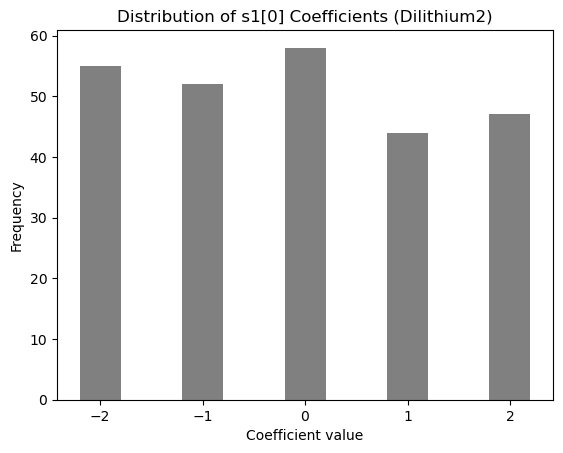

In [81]:
coeffs = sk_data["s1"][0]

values = range(-2, 3)
counts = [coeffs.count(v) for v in values]

plt.bar(values, counts, width=0.4, color="grey")

plt.title("Distribution of s1[0] Coefficients (Dilithium2)")
plt.xlabel("Coefficient value")
plt.ylabel("Frequency")
plt.xticks(values)

plt.show()

## Sign a Message with Dilithium2

Dilithium signs a message $M$ using the secret key $\mathrm{sk} = (\rho, K, \mathrm{tr}, s_1, s_2, t_0)$ and produces a signature

$$
\sigma = (z, h, c)
$$

where $z$ is a short vector of polynomials, $h$ is a hint vector, and $c$ is the challenge.

### 1. Hash the message and bind to the public key

Compute:

$$
\mu = H(\mathrm{tr} \,\|\, M)
$$

This ties the signature to the public key via $\mathrm{tr} = H(\rho \,\|\, t_1)$. Note that the hash of the public key $\mathrm{tr}$ is stored in the secret key to save one hashing operation.

### 2. Compute the commitment $w$

Regenerate the public matrix $A = \mathrm{ExpandA}(\rho)$ and compute:

$$
w = A y
$$

where $y \in R_q^{l}$ is a short random vector derived deterministically from the secret signing seed K and the public key. Decompose $w$ into high and low bits where $w_1$ are the high bits and $w_0$ are the low bits.

### 3. Compute the challenge $c$

$$
c = H(\mu \,\|\, w_1)
$$

### 4. Form the candidate response $z$

$$
z = y + c s_1
$$

Reject if $z$ is not small enough (norm bound).

### 5. Compute compute the hint vector $h$ (omitted for simplicity)

The hint allows the verifier to reconstruct $w_1$ despite rounding/compression. Reject if the hint is too large (weight bound).

### 6. Output the signature

If all checks pass, output:

$$
\sigma = (z, h, c)
$$

In [93]:
message1 = b"Hello Dilithium2"

sigma = Dilithium2.sign(sk, message1)

print("Signature length (Byte):", len(sigma))

Signature length (Byte): 2420


Let's unpack the signature into it's three component polynomials $z$, $h$, and $c$:

In [94]:
sig_data = unpack_sig_dilithium2(sigma)

print("Challenge c:", sig_data["c"].hex())
print("First 10 coeffs of candidate response component polynomial z[0]:", sig_data["z"][0][:10])
print("Number of 1s in hint vector h[0]:", sum(sig_data["h"][0]))

Challenge c: 33abbda89959d194a1c7efa00c656a57a8b3569bb79370ed28e55a88830bc65c
First 10 coeffs of candidate response component polynomial z[0]: [28908, -19974, -27742, -109049, 83149, -8366, 28442, 49161, 103345, -12864]
Number of 1s in hint vector h[0]: 12


## Verify a Dilithium2 Signature

Given the public key $\mathrm{pk} = (\rho, t_1)$, a message $M$, and a signature $\sigma = (z, h, c)$,  the verifier checks whether the signature is valid.

### 1. Recompute the message hash

First compute:

$$
\mathrm{tr} = H(\rho \,\|\, t_1)
$$

Note that $\mathrm{tr}$ is not stored as a precomputed value in the public key to save 64 bytes at the cost of one (fast) hash operation. Then compute:

$$
\mu = H(\mathrm{tr} \,\|\, M)
$$

This mimics the first step in the signature generation and binds the message to the public key.

### 2. Regenerate the public matrix

Using the seed $\rho$:

$$
A = \mathrm{ExpandA}(\rho)
$$

### 3. Compute the reconstructed commitment

Compute:

$$
w' = A z - c t_1 \cdot 2^d
$$

This mirrors the signer’s computation of $w$. Note that the public key stores only the high bits $t_1$ for compression, therefore the multiplication includes the factor $2^d$.

### 4. Use the hint to reconstruct high bits

Using the hint vector $h$, reconstruct:

$$
w_1' = \mathrm{UseHint}(w', h)
$$

This step recovers the high bits of the commitment. The verifier does not know $t_0$, so computing $w^\prime$ is off by the missing term using $t_0$. The hint compensates for that missing information enough to reconstruct $w_1^\prime$, but without leaking information about the secret key. This is just as tricky as it sounds :)


### 5. Recompute the challenge

$$
c' = H(\mu \,\|\, w_1')
$$


### 6. Accept or Reject

The signature is **valid** if:

- $c' = c$
- $z$ satisfies the required norm bound

Otherwise, reject.

In [99]:
message2 = b"Hello Dilithium2"
# Change message2 to make the verification fail

is_valid = Dilithium2.verify(pk, message2, sigma)

print("Signature valid:", is_valid)

Signature valid: True
